# Natural Language Processing with Disaster Tweets

# Competition Description

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:

In [1]:
import pandas as pd
import spacy
from sklearn.model_selection import GridSearchCV

In [2]:
tweets_file = '/Users/aitorelordizamora/Documents/input/nlp_disaster/train.csv'
df = pd.read_csv(tweets_file, header=0)
display(df)
df =df[['text','target']]
df.isnull().sum()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


text      0
target    0
dtype: int64

In [3]:
tweets = [tuple(x) for x in df.values]
print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))

Número de Tweets Cargados: 7613


# Normalización

. Para este ejemplo haremos uso de spaCy, pero en este caso tenemos que utilizar (e importar) el modelo para Inglés.

. Para normalizar los tweets realizaremos las siguientes acciones:

    Pasamos las frases a minúsculas.
    Eliminamos los signos de puntuación.
    Eliminamos las palabras con menos de 3 caracteres.
    Eliminamos las Stop-Words.
    Eliminamos las palabras que empiecen por '@' o 'http'.
    Pasamos la palabra a su lema
    
. Todos estos pasos los vamos a realizar en una misma función.


In [4]:
nlp = spacy.load('en_core_web_sm')

# Divido los datos en dos listas 
#     X: los tweets
#     y: target (polaridad)

X = [doc[0] for doc in tweets]
y = [doc[1] for doc in tweets]

def normalize(sentenses):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, sentense in enumerate(sentenses):
        sentense = nlp(sentense.lower()) # Paso la frase a minúsculas y a un objeto de la clase Doc de Spacy
        sentenses[index] = " ".join([word.lemma_ for word in sentense if (not word.is_punct)
                                     and (len(word.text) > 2) and (not word.is_stop) 
                                     and (not word.text.startswith('@')) and (not word.text.startswith('http'))])
    return sentenses

# Normalizamos las frases
X = normalize(X)

# Bolsa de Palabras

   . El siguiente paso es transformar los tweets a una bolsa de palabras de frecuencias para que sirva de entrada al modelo.

   . Dado que ya estamos trabajando con un corpus relativamente grande, es necesario reducir el diccionario de palabras (no confundir con un diccionario Python) para trabajar solo con las palabras más relevantes.

   . La implementación de la clase "CountVectorizer" de scikit, permite quedarnos con las palabras más relevante. Para ello podemos utilizar dos parámetros que son:

   . max_features: Con este parámetro le indicamos que nos seleccione la 'X' palabras más frecuentes del corpus. En este ejemplo seleccionaremos las 1000 más frecuentes.

   . min_df: Con este parámetro le indicamos el número mínimo de documentos en la que tiene que aparecer la palabra para que se incluya en la bolsa de palabras. En este ejemplo seleccionaremos 10 documentos (tweets).

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000, min_df=30)

# Pasamos los tweets normalizados a Bolsa de palabras
X = vectorizer.fit_transform(X)

# Particionado de Datos (Train y Test)

Vamos a particionar los datos en conjunto de Train y Test.
Para este ejemplo nos vamos a quedar con:

    80% de datos de entrenamiento
    20% de datos de test

In [6]:
from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('Número de Tweets para el entrenamiento: {num}'.format(num=X_train.shape[0]))
print('Número de Tweets para el test: {num}'.format(num=X_test.shape[0]))

Número de Tweets para el entrenamiento: 6090
Número de Tweets para el test: 1523


# Creacción del Modelo

Una vez tenemos creada la bolsa de palabras, podemos usar cualquier algoritmo de aprendizaje para la clasificación.
Para este ejemplo vamos a usar los siguientes algoritmos de aprendizaje:

   Multinomial Naive Bayes:https://scikitlearn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
   
   Bernoulli Naive Bayes: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html
   
   Regresion Logistica: 
   https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
   
   Support Vector Machine Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
   
   Random Forest (ensemble): 
   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    
Para esta caso vamos a crear el modelo y calcular el accuracy para los datos de entrenamiento y tener una idea de que modelo puede funciona mejor:

In [17]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

mnb = MultinomialNB()
bnb = BernoulliNB()
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
svm_lin = SVC(kernel='linear')
svm_rbf = SVC(kernel='rbf')
rf_50 = RandomForestClassifier(n_estimators=500, bootstrap=True, criterion='gini', max_depth=50, random_state=0)
xgb= xgb.XGBClassifier(objective='multi:softmax',num_class=len(set(y_train)),learning_rate=0.1,max_depth=6,n_estimators=100,n_jobs=-1,random_state=42)

clasificadores = {'Multinomial NB': mnb,
                  'Bernoulli NB': bnb,
                  'Regresion Logistica': lr,
                  'SVM lineal': svm_lin,
                  'SVM Kernel rbf': svm_rbf,
                  'Random Forest d_50': rf_50,
                  'XGBOOST':xgb}


# Ajustamos los modelos y calculamos el accuracy para los datos de entrenamiento
for k, v in clasificadores.items():
    print ('CREANDO MODELO: {clas}'.format(clas=k))
    v.fit(X_train, y_train)

CREANDO MODELO: Multinomial NB
CREANDO MODELO: Bernoulli NB
CREANDO MODELO: Regresion Logistica
CREANDO MODELO: SVM lineal
CREANDO MODELO: SVM Kernel rbf
CREANDO MODELO: Random Forest d_50
CREANDO MODELO: XGBOOST


# Evaluación del Modelo

Para cada uno de los modelos vamos a calcular las siguientes métricas de evaluación:

   Accuracy: Es la fracción de ejemplos clasificados correctamente por el modelo. Se calcula como el número de ejemplos clasificados correctamente dividido por el número total de ejemplos. La exactitud es una buena medida general del rendimiento del modelo, especialmente cuando las clases están equilibradas.
   
   Precision: Es la fracción de ejemplos clasificados como positivos que son verdaderamente positivos. Es decir, es la proporción de verdaderos positivos (VP) entre los verdaderos positivos y falsos positivos (FP). La precisión es una métrica importante cuando es importante minimizar los falsos positivos.
   
   Recall: Es la fracción de ejemplos positivos que son identificados correctamente por el modelo. Es decir, es la proporción de verdaderos positivos (VP) entre los verdaderos positivos y falsos negativos (FN). El recall es una métrica importante cuando es importante minimizar los falsos negativos.
   
   F1:Es la media armónica de la precisión y el recall. Combina ambas métricas en una sola puntuación que resume el rendimiento del modelo. El F1 score es una métrica comúnmente utilizada cuando se desea tener en cuenta tanto la precisión como el recall de un modelo. El valor de F1 score oscila entre 0 y 1, siendo 1 la mejor puntuación.






In [18]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

def evaluation(model, name, X_train, y_train, X_test, y_test):
    """
    Función de devuelve en un diccionario las métricas de evaluación de 
    Accuracy, Precision, Recall y F1 para los conjuntos de datos de entrenamiento y test
        model: modelo a evaluar
        name: nombre del modelo
        X_train: Variables de entrada del conjunto de datos de entrenamiento
        y_train: Variable de salida del conjunto de datos de entrenamiento
        X_test: Variables de entrada del conjunto de datos de test
        y_test: Variable de salida del conjunto de datos de test
        return: diccionario con el nombre del modelo y el valor de las métricas
    """
    model_dict = {}
    model_dict['name'] = name
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    model_dict['accuracy_train'] = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    model_dict['accuracy_tests'] = accuracy_score(y_true=y_test, y_pred=y_pred_test)
    model_dict['precision_train'] = precision_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['precision_tests'] = precision_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    model_dict['recall_train'] = recall_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['recall_tests'] = recall_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    model_dict['f1_train'] = f1_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['f1_tests'] = f1_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    
    return model_dict


# Calculamos las métricas de los modelos por separado
evaluacion = list()
for key, model in clasificadores.items():
    evaluacion.append(evaluation(model=model, name=key, 
                                 X_train=X_train, y_train=y_train,
                                 X_test=X_test, y_test=y_test))

# Pasamos los resultados a un DataFrame para visualizarlos mejor
df = pd.DataFrame.from_dict(evaluacion)
df.set_index("name", inplace=True)
df

,accuracy_train,accuracy_tests,precision_train,precision_tests,recall_train,recall_tests,f1_train,f1_tests
name,,,,,,,,
Multinomial NB,0.781445,0.760998,0.781166,0.759678,0.781445,0.760998,0.779488,0.758153
Bernoulli NB,0.789819,0.768221,0.793538,0.769986,0.789819,0.768221,0.785776,0.762803
Regresion Logistica,0.810181,0.787262,0.811932,0.790398,0.810181,0.787262,0.807748,0.782237
SVM lineal,0.808703,0.782009,0.811010,0.784791,0.808703,0.782009,0.805977,0.776860
SVM Kernel rbf,0.884072,0.795798,0.888451,0.799402,0.884072,0.795798,0.882576,0.791025
Random Forest d_50,0.844499,0.772160,0.871146,0.790720,0.844499,0.772160,0.837848,0.759733
XGBOOST,0.784401,0.760998,0.807997,0.777699,0.784401,0.760998,0.773617,0.747873


Representamos las métricas para los diferentes modelos en un gráfico de barras:

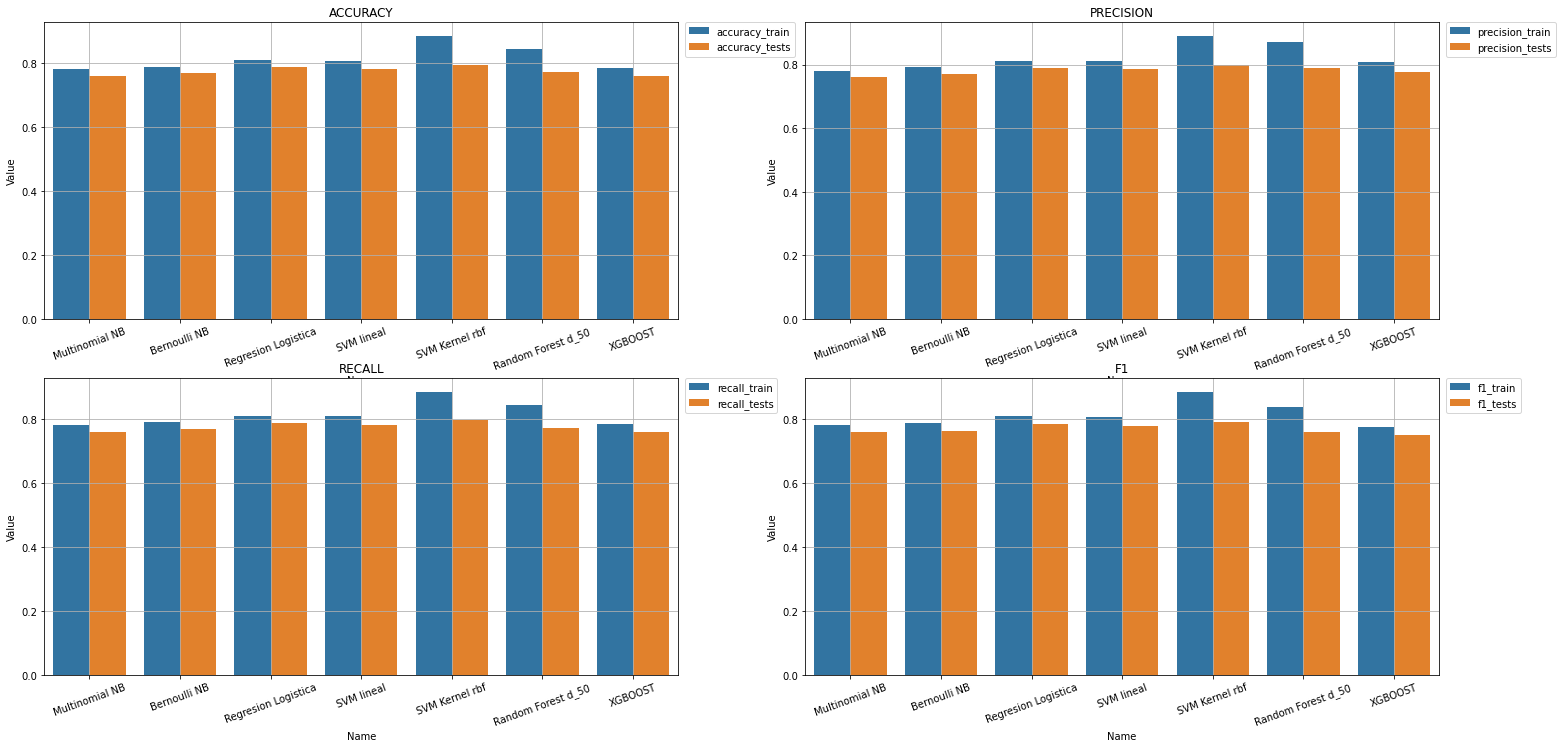

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Métricas a pintar
METRICS = ["accuracy", "precision", "recall", "f1"]

# Transformamos el dataframe para pintar las gráficas con seaborn
df_plot = df.reset_index().melt(id_vars='name').rename(columns=str.title)

plt.figure(figsize=(25, 12))
pos = 1
for metric in METRICS:
    # Filtramos la métrica a pintar
    df_aux = df_plot[df_plot['Variable'].str.contains(metric)]
    
    # Pintamos la gráfica en su posición 2x2
    plt.subplot(2, 2, pos)
    sns.barplot(x='Name', y='Value', hue='Variable', data=df_aux)
    plt.title(metric.upper())
    plt.grid()
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.xticks(rotation=20)
    pos += 1
plt.show()

Veamos las matrices de confusión de los modelos

Obteniendo Matriz de Confusión de: Multinomial NB
Obteniendo Matriz de Confusión de: Bernoulli NB
Obteniendo Matriz de Confusión de: Regresion Logistica
Obteniendo Matriz de Confusión de: SVM lineal
Obteniendo Matriz de Confusión de: SVM Kernel rbf
Obteniendo Matriz de Confusión de: Random Forest d_50
Obteniendo Matriz de Confusión de: XGBOOST


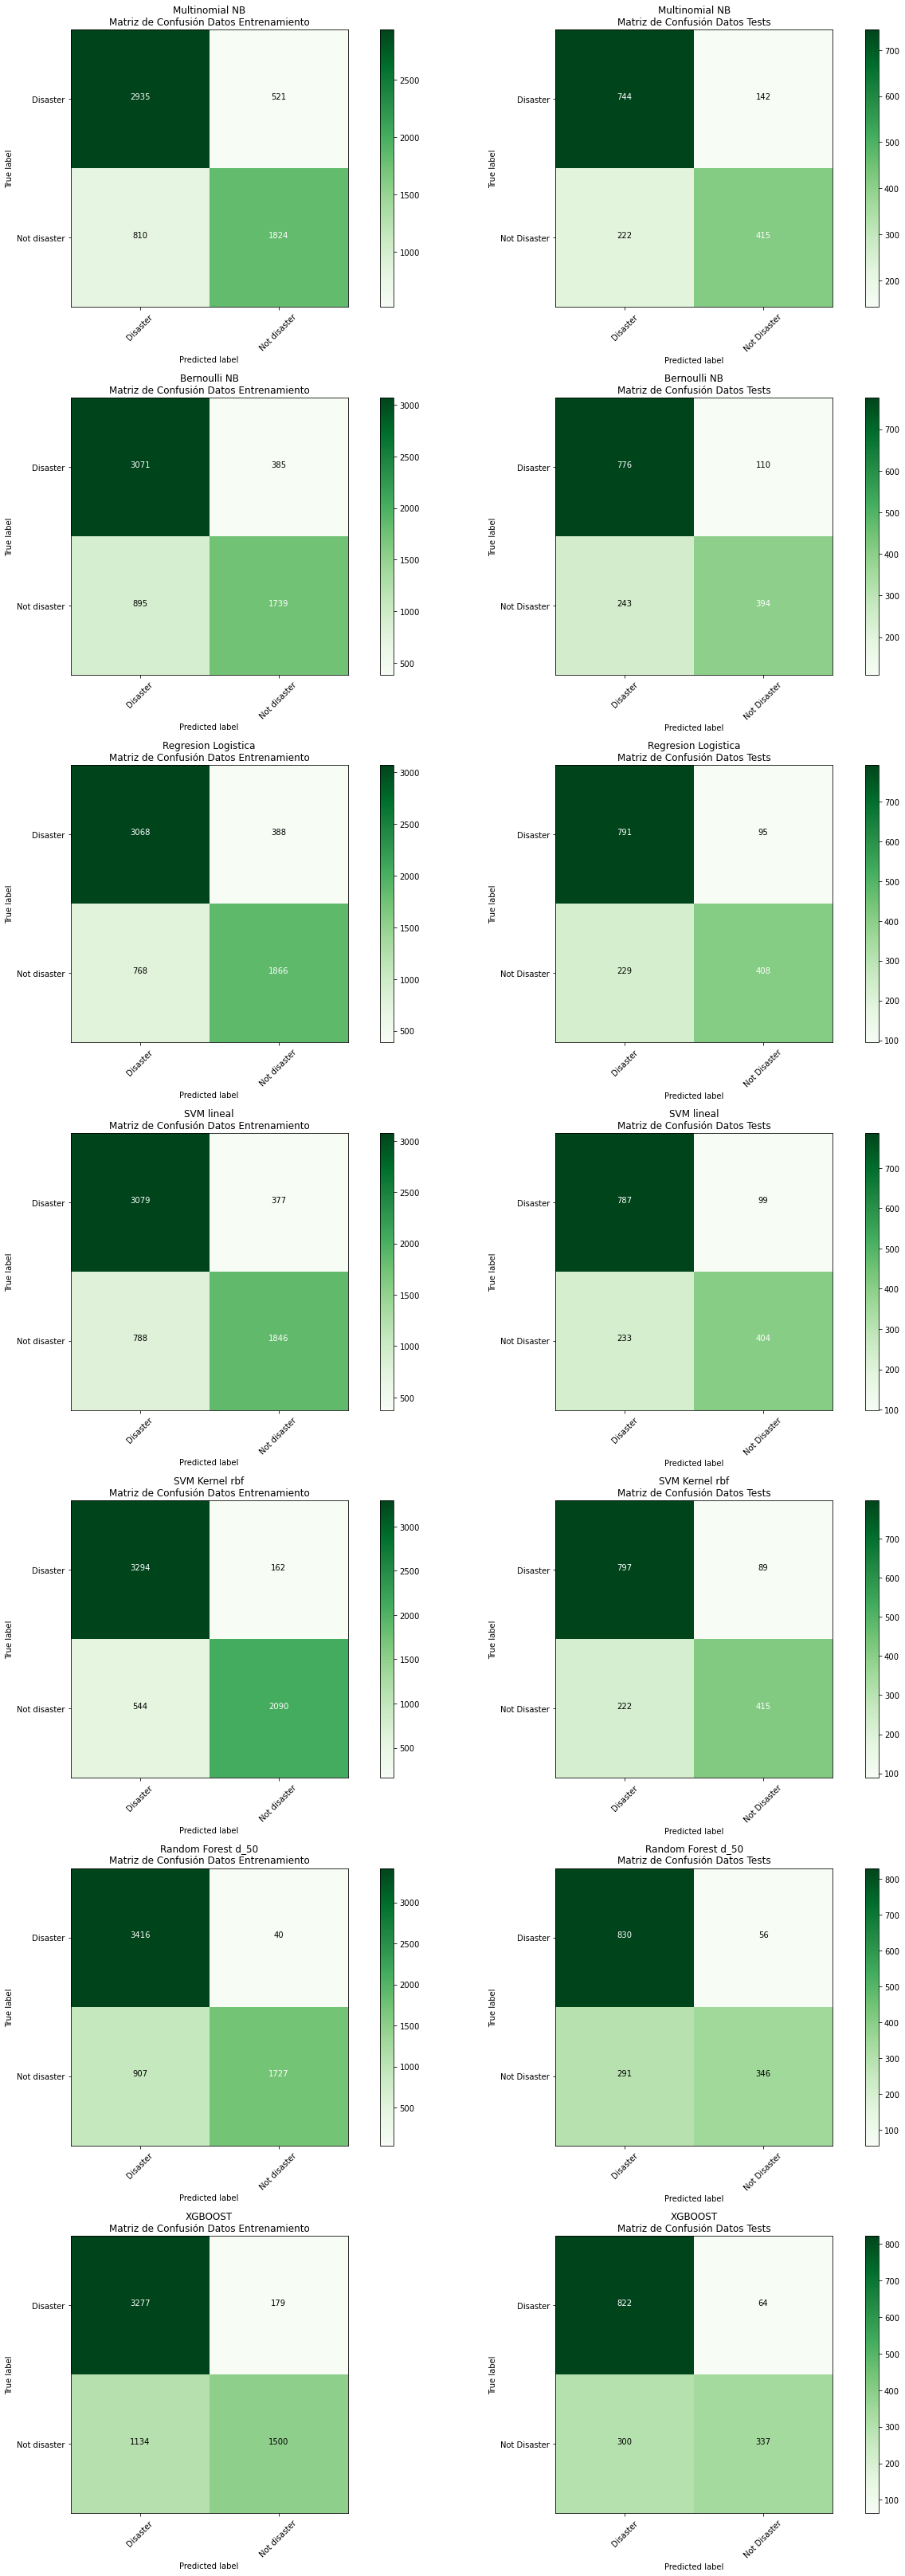

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

from sklearn.metrics import confusion_matrix

# Obtenemos las Matrices de confusión
msc = list()
for k, v in clasificadores.items():
    print ('Obteniendo Matriz de Confusión de: {model}'.format(model=k))
    model = {}
    model['name'] = k
    y_pred_train = v.predict(X_train)
    y_pred_test = v.predict(X_test)
    model['confusion_matrix_train'] = confusion_matrix(y_true=y_train, y_pred=y_pred_train)
    model['confusion_matrix_test'] = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
    msc.append(model)

    
# Definimos el heatmap de la matriz de confusión
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Pintamos las matrices de confusión
plt.figure(figsize=(20, 45))
pos = 0
for mc in msc:
    pos += 1
    plt.subplot(7, 2, pos)
    plot_confusion_matrix(mc['confusion_matrix_train'], classes=['Disaster','Not disaster'], 
                          title='{}\nMatriz de Confusión Datos Entrenamiento'.format(mc['name']))
    pos += 1
    plt.subplot(7, 2, pos)
    plot_confusion_matrix(mc['confusion_matrix_test'], classes=['Disaster', 'Not Disaster'], 
                          title='{}\nMatriz de Confusión Datos Tests'.format(mc['name'] ))
plt.show()

In [11]:
tweets_file = '/Users/aitorelordizamora/Documents/input/nlp_disaster/test.csv'
df = pd.read_csv(tweets_file, header=0)
display(df)
df1 = df[['id','text']]
df2 = df1[['text']]
df.isnull().sum()

#---------------------------------------------------------------------------------------
tweets = [tuple(x) for x in df2.values]
print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))

#---------------------------------------------------------------------------------------
nlp = spacy.load('en_core_web_sm')

# Divido los datos en dos listas 
#     X: los tweets
#     y: target (polaridad)

X2 = [doc[0] for doc in tweets]
#---------------------------------------------------------------------------------------

def normalize(sentenses):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, sentense in enumerate(sentenses):
        sentense = nlp(sentense.lower()) # Paso la frase a minúsculas y a un objeto de la clase Doc de Spacy
        sentenses[index] = " ".join([word.lemma_ for word in sentense if (not word.is_punct)
                                     and (len(word.text) > 2) and (not word.is_stop) 
                                     and (not word.text.startswith('@')) and (not word.text.startswith('http'))])
    return sentenses

# Normalizamos las frases
X2 = normalize(X2)

#---------------------------------------------------------------------------------------

#vectorizer = CountVectorizer(max_features=1000, min_df=10)

# Pasamos los tweets normalizados a Bolsa de palabras

X2 = vectorizer.transform(X2)

#---------------------------------------------------------------------------------------

rf_50 = RandomForestClassifier(n_estimators=500, bootstrap=True, criterion='gini', max_depth=50, random_state=0)

display(X2)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


Número de Tweets Cargados: 3263


<3263x418 sparse matrix of type '<class 'numpy.int64'>'
	with 10612 stored elements in Compressed Sparse Row format>

# Predicción

In [22]:
#Gridsearch-SVC------------------------------------------------------------------------------------

param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid)
svc = SVC(kernel='rbf')
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


best_svc = SVC(kernel='rbf', C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'])
best_svc.fit(X_train, y_train)

#Gridsearch-RANDOM FOREST------------------------------------------------------------------------------------


rf = RandomForestClassifier()
params = {'n_estimators': [50, 100, 200],'max_features': ['sqrt', 'log2'],'max_depth': [5, 10, 20, None],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}
grid_search = GridSearchCV(rf, params, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

rf_best = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'],
                                 max_features=grid_search.best_params_['max_features'],
                                 max_depth=grid_search.best_params_['max_depth'],
                                 min_samples_split=grid_search.best_params_['min_samples_split'],
                                 min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                                 random_state=42)


rf_best.fit(X_train, y_train)


'''

clasificadores = {#'Multinomial NB': mnb,
                  #'Bernoulli NB': bnb,
                  #'Regresion Logistica': lr,
                  #'SVM lineal': svm_lin,
                  'SVM Kernel rbf': svm_rbf,
                  #'Random Forest d_50': rf_50
}


# Ajustamos los modelos y calculamos el accuracy para los datos de entrenamiento

for k, v in clasificadores.items():
    
    print ('CREANDO MODELO: {clas}'.format(clas=k))
    v.fit(X_train, y_train)

'''

#Realizo la prediccion para los datos test

ids = df1['id']
predictions = rf_best.predict(X2)


output = pd.DataFrame({
    'id': ids,
    'target' : predictions
})

output.to_csv('submission_nlp_svm_disaster.csv', index=False)

Best parameters:  {'C': 10, 'gamma': 0.1}
Best score:  0.783415435139573
Best parameters:  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best score:  0.7852216748768474


In [15]:
display(output)


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
